# Texture archives

Sticking to the game plan, the textures had a lot of overlap between patches. Lower file size can be easier to handle. `rimage.zbd` clocks in at 39 MiB, `rmechtex.zbd` at 31 MiB, and `rmechtex16.zbd` and `rmechtexs.zbd` at 8.8 MiB. Hmm, now that's interesting. They do differ in contents, and I'm not sure why they'd be the same, but this is a good indication that there is no texture compression (the odds would be astronomical). Some of the campaign folders also have textures, which I can also check.

Now, what's the chance it's the same archive format as for the sounds?

In [1]:
from pathlib import Path
from struct import unpack_from, Struct

path = Path("install/v1.0-us-post/zbd/rmechtexs.zbd")
data = path.read_bytes()

unpack_from("<2I", data, len(data) - 8)

(1388989033, 1384663720)

Booo! Looks like a new archive format, so starting from scratch.

In [2]:
data[:32]

b'\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\xee\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00annihila'

Always good to see strings. That string is at position 24. And before that looks like 4 byte (32 bit) integers, so 24 / 4 = 6 of them:

In [3]:
unpack_from("<6I8s", data, 0)

(0, 1, 0, 2286, 0, 0, b'annihila')

That's better!

In [4]:
zbd = Path("install/v1.0-us-post/zbd")

s1 = Struct("<6I8s")

for tex_path in zbd.rglob("rmechtex*.zbd"):
    with tex_path.open("rb") as f:
        print(tex_path, s1.unpack_from(f.read(s1.size), 0), sep="\t")

install/v1.0-us-post/zbd/rmechtex.zbd	(0, 1, 0, 3360, 0, 0, b'annihi_d')
install/v1.0-us-post/zbd/rmechtex16.zbd	(0, 1, 0, 2286, 0, 0, b'annihila')
install/v1.0-us-post/zbd/rmechtexs.zbd	(0, 1, 0, 2286, 0, 0, b'annihila')


OK, great, it holds. Digging deeper.

In [5]:
data[24:128]

b'annihilator01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00He\x01\x00\xff\xff\xff\xffannihilator01_b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00X\x85\x01\x00\xff\xff\xff\xffannihilator01_c\x00\x00\x00\x00\x00\x00\x00\x00\x00'

In [6]:
data[24 : 24 + 40], data[24 + 40 : 24 + 40 * 2]

(b'annihilator01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00He\x01\x00\xff\xff\xff\xff',
 b'annihilator01_b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00X\x85\x01\x00\xff\xff\xff\xff')

Zero-terminated strings of a fixed length. Record size of 40. Wonder if that fourth integer is the record count?

In [7]:
header = unpack_from("<6I", data, 0)
count = header[3]

offset = 24
for i in range(count):
    name = data[offset : offset + 32].rstrip(b"\0").decode("ascii")
    # Compress this a bit to avoid spam
    if i < 5 or i > count - 5:
        print(name, end=" ")
    offset += 40

annihilator01 annihilator01_b annihilator01_c annihilator01_d annihilator01_e vulture_317_f vulture_317_g vulture_317_h weap_hole 

Not bad. So, we have 8 bytes left per record. However, the last 4 bytes seem to be 0xFFFFFFFF. Hopefully, the other value is an offset for more data?

In [8]:
record = Struct("<32s2I")
data_size = len(data)

offset = 24
prev = 0
for i in range(count):
    name, start, magic = record.unpack_from(data, offset)
    assert magic == 0xFFFFFFFF  # see if it's constant
    assert start < data_size
    assert start > prev  # see if it's ordered
    prev = start
    offset += record.size
    name = name.rstrip(b"\0").decode("ascii")
print(prev, data_size, data_size - prev)

9195544 9195816 272


272 is pretty small for a texture. Maybe "weapon hole" is a small impact texture? So one assumption could be that the data goes all the way to the end of the file. I'm not sure why they didn't use the `magic` value to store the length of each texture (or the end offset), but we can fill in the blanks based on `start` of the previous item:

In [9]:
offset = 24
items = []
for i in range(count):
    name, start, magic = record.unpack_from(data, offset)
    assert magic == 0xFFFFFFFF
    offset += record.size
    name = name.rstrip(b"\0").decode("ascii")
    items.append((name, start))
items.append((None, data_size))

textures = {}
for i in range(count):
    name, start = items[i]
    _, end = items[i + 1]
    if name in textures:
        print("dupe", name)
    textures[name] = data[start:end]

Excellent. So I'm thinking it would be worth finding out if the texture data have some common lengths. It's already likely they aren't compressed, but the lengths can help determine the structure.

In [10]:
unique_lengths = {len(texture) for texture in textures.values()}
unique_lengths

{272, 528, 1040, 2064, 3088, 4112, 8208, 16400}

Based on this, there is definitely no compression (in this one). Another bit of information is none of those lengths are powers of two. Texture width and height were usually powers of two, for archaic performance reasons to do with fast multiplication and division of powers of two. But the textures need headers for e.g. dimensions, which we haven't found yet. And those values are awfully close to powers of two:

* 528 - 512 = 16
* 1040 - 1024 = 16
* 2064 - 2048 = 16

So the header size is 16 bytes, or 4x4 byte integers.

In [11]:
{unpack_from("<4I", texture, 0) for texture in textures.values()}

{(5, 524304, 0, 0),
 (5, 1048584, 0, 0),
 (5, 1048592, 0, 0),
 (5, 1048608, 0, 0),
 (5, 1048640, 0, 0),
 (5, 2097160, 0, 0),
 (5, 2097168, 0, 0),
 (5, 2097184, 0, 0),
 (5, 2097216, 0, 0),
 (5, 2097280, 0, 0),
 (5, 4194320, 0, 0),
 (5, 4194336, 0, 0),
 (5, 4194368, 0, 0),
 (5, 4194432, 0, 0),
 (5, 8388624, 0, 0),
 (5, 8388640, 0, 0),
 (5, 8388672, 0, 0),
 (11, 1048640, 0, 0)}

That's good news, there's significant communality between the textures. But the header isn't quite right.

Conjecture/rant time. So the second integer is probably two 2 byte integers (16 bit). But why? Ultimately, we might never know. Some file formats are just ported over from older projects. On the one hand, textures of the size 65535x65535 (the maximum 16 bit values) are ludicrously large for the 90s. But why encode them like that? Those 0xFFFFFFFF bytes on the records are also "wasted", and a record size of 40 is no more efficient to load than 36. It's all very odd.

Anyway, this is where more data will help. Those zero fields could be set for textures in the other archives. But first, let's figure out if we can determine the dimensions. Come to think of it, this is probably why the length is not stored in the record table. If you know the header size and image data size, you can figure out how much data to load (although currently, we don't have quite enough information for that).

In [12]:
{unpack_from("<I6H", texture, 0) for texture in textures.values()}

{(5, 8, 16, 0, 0, 0, 0),
 (5, 8, 32, 0, 0, 0, 0),
 (5, 16, 8, 0, 0, 0, 0),
 (5, 16, 16, 0, 0, 0, 0),
 (5, 16, 32, 0, 0, 0, 0),
 (5, 16, 64, 0, 0, 0, 0),
 (5, 16, 128, 0, 0, 0, 0),
 (5, 32, 16, 0, 0, 0, 0),
 (5, 32, 32, 0, 0, 0, 0),
 (5, 32, 64, 0, 0, 0, 0),
 (5, 32, 128, 0, 0, 0, 0),
 (5, 64, 16, 0, 0, 0, 0),
 (5, 64, 32, 0, 0, 0, 0),
 (5, 64, 64, 0, 0, 0, 0),
 (5, 64, 128, 0, 0, 0, 0),
 (5, 128, 32, 0, 0, 0, 0),
 (5, 128, 64, 0, 0, 0, 0),
 (11, 64, 16, 0, 0, 0, 0)}

Dimensions: decoded. So usually, to figure out the size of the image data, you need width, height, and how many bytes per pixel (BPP) there are, aka. the bit depth. But since we already have the size, that means the BPP can be calculated.

In [13]:
bpp = set()
for texture in textures.values():
    _, width, height = unpack_from("<I2H", texture, 0)
    size = (
        width * height
    )  # this way, it doesn't matter if we get these the wrong way round
    bytes_per_pixel = (len(texture) - 16) / size
    bpp.add(bytes_per_pixel)
bpp

{2.0, 3.0}

Two bit depths, and two values for the first integer? Suspicious...

In [14]:
bpp = set()
for texture in textures.values():
    ident, width, height = unpack_from("<I2H", texture, 0)
    size = (
        width * height
    )  # this way, it doesn't matter if we get these the wrong way round
    bytes_per_pixel = (len(texture) - 16) / size
    bpp.add((ident, bytes_per_pixel))
bpp

{(5, 2.0), (11, 3.0)}

Cool. So the first value corresponds to the image format. 3 bytes per pixel should be just RGB. 2 bytes per pixel is probably not palette-based, but instead [16-bit RGB](https://docs.microsoft.com/en-us/windows/win32/directshow/working-with-16-bit-rgb), which can be encoded as 5 bits per component (highest bit ignored), or RGB 565. Luckily, I have some of the most advanced image decoding instruments on the planet - eyes. Let's find a texture with the format "5". Because the way the data is stored (little endian), it's possible find a matching texture without decoding the header:

In [15]:
next(name for name, texture in textures.items() if texture[0] == 5)

'annihilator01'

First, a little sanity check though. If the image is displayed in 8-bit grey scale, with 16-bit RGB you'd expect to get a jumbled mess since the pixel data doesn't align to 8-bit boundaries. Since it's 2 BPP, one dimension has to be stretched. Logically, if each pixel is 2 bytes, stretching width-wise makes sense. But I'll do both here just to check if some structure becomes apparent with the width preserved.

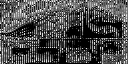

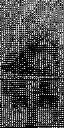

In [16]:
from helpers import display_image
from PIL import Image

# hard-coded for repeatability
texture = textures["annihilator01"]
ident, width, height = unpack_from("<I2H", texture, 0)

img = Image.frombytes("L", (width * 2, height), texture[16:])
display_image(img, width="250px")
img = Image.frombytes("L", (width, height * 2), texture[16:])
display_image(img, width="125px")

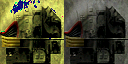

In [17]:
size = width * height
pixels = unpack_from(f"<{size}H", texture, 16)


def rgb15_to_24(pixels):
    for pixel in pixels:
        yield ((pixel >> 10) & 0b11111) << 3
        yield ((pixel >> 5) & 0b11111) << 3
        yield ((pixel >> 0) & 0b11111) << 3


def rgb16_to_24(pixels):
    for pixel in pixels:
        yield ((pixel >> 11) & 0b11111) << 3
        yield ((pixel >> 5) & 0b111111) << 2
        yield ((pixel >> 0) & 0b11111) << 3


compare = Image.new("RGB", (width * 2, height))
for i, decode_fn in enumerate([rgb15_to_24, rgb16_to_24]):
    img = Image.frombytes("RGB", (width, height), bytes(decode_fn(pixels)))
    compare.paste(img, (width * i, 0))
display_image(compare, width="500px")

Decoding as RGB 555 has some artefacts. RGB 565 looks perfect! One more thing: using a non-square image to check if it's (width, height) or (height, width). Because so far, the code has been agnostic.

In [18]:
def rgb16_not_square(texture):
    ident, width, height = unpack_from("<I2H", texture, 0)
    return ident == 5 and width != height


next(name for name, texture in textures.items() if rgb16_not_square(texture))

'annihilator06'

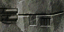

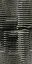

In [19]:
# hard-coded for repeatability
texture = textures["annihilator06"]
ident, width, height = unpack_from("<I2H", texture, 0)
size = width * height

pixels = unpack_from(f"<{size}H", texture, 16)

img = Image.frombytes("RGB", (width, height), bytes(rgb16_to_24(pixels)))
display_image(img, width="250px")

img = Image.frombytes("RGB", (height, width), bytes(rgb16_to_24(pixels)))
display_image(img, width="125px")

I know which one I prefer. Next format please! This should be easy, right? 3 BPP must be RGB!

In [20]:
name = next(name for name, texture in textures.items() if texture[0] == 11)
name

'stump_damage02'

In [21]:
texture = textures["stump_damage02"]
ident, width, height = unpack_from("<I2H", texture, 0)
size = width * height
img = Image.frombytes("RGB", (width, height), texture[16:])
display_image(img, width="500px")

Oh. But the 3 BPP is too perfect, there must be some kind of structure. As before, let's see if grey scale shows anything.

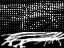

In [22]:
img = Image.frombytes("L", (width * 3, height), texture[16:])
display_image(img, width="750px")
img = Image.frombytes("L", (width, height * 3), texture[16:])
display_image(img, width="250px")

Okay, this is highly interesting. The first 2/3 again looks like a jumbled mess, which suggests 16-bit RGB. But the last 1/3 looks sensible. This suggests an 8-bit grey scale image, most likely an alpha channel.

In [23]:
pixels = unpack_from(f"<{size}H", texture, 16)

img = Image.frombytes("RGB", (width, height), bytes(rgb16_to_24(pixels)))
alpha = Image.frombytes("L", (width, height), texture[16 + size * 2 :])
img.putalpha(alpha)
display_image(img, width="250px")

In [24]:
red = Image.new("RGBA", img.size, color=(255, 0, 0))
display_image(Image.alpha_composite(red, img), width="250px")

It isn't the clearest example, but looks like an alpha channel to me, and one that is not pre-multiplied. Mechwarrior 3 used DirextX 6, which still used DirectDraw to load textures. Alpha channels could have various bit depths, so why did they use the full 8 bits? (As an exercise, you can quantise/reduce the alpha channel bit depth by e.g. masking the lower bits. To me, 4 bits looks as good as 8 bits.)

Anyway, it doesn't matter. We have a way of decoding all the images in this file, let's see what the other files yield. I'm again calculating start and end, since if any unknown image formats are in there, I can't yet calculate the expected data size.

But which header to look at next?

In [25]:
zbd_header = Struct("<6I")
tex_record = Struct("<32s2I")
tex_header = Struct("<I6H")


def read_textures(data):
    z1, one, z2, count, z3, z4 = zbd_header.unpack_from(data, 0)
    assert z1 == 0, "z1"
    assert z2 == 0, "z2"
    assert z3 == 0, "z3"
    assert z4 == 0, "z4"
    assert one == 1, "one"

    items = []
    offset = zbd_header.size
    for i in range(count):
        name, start, magic = tex_record.unpack_from(data, offset)
        assert magic == 0xFFFFFFFF  # see if it's constant
        name = name.rstrip(b"\0").decode("ascii")
        items.append((name, start))
        offset += tex_record.size
    items.append((None, len(data)))

    textures = {}
    for i in range(count):
        name, start = items[i]
        _, end = items[i + 1]
        if name in textures:
            print("dupe", name)
        texture = data[start:end]
        header = tex_header.unpack_from(texture, 0)
        textures[name] = (header, texture[tex_header.size :])

    return textures

In [26]:
def header_set(path):
    textures = read_textures(path.read_bytes())
    print(path, {(header[0],) + header[3:] for header, _ in textures.values()})


header_set(Path("install/v1.0-us-post/zbd/rmechtexs.zbd"))
header_set(Path("install/v1.0-us-post/zbd/rmechtex.zbd"))
header_set(Path("install/v1.2-us-post/zbd/rmechtex.zbd"))
header_set(Path("install/v1.0-us-post/zbd/rmechtex16.zbd"))
header_set(Path("install/v1.0-us-post/zbd/rimage.zbd"))

install/v1.0-us-post/zbd/rmechtexs.zbd {(5, 0, 0, 0, 0), (11, 0, 0, 0, 0)}
install/v1.0-us-post/zbd/rmechtex.zbd {(5, 0, 0, 0, 0), (11, 0, 0, 0, 0)}
install/v1.2-us-post/zbd/rmechtex.zbd {(5, 0, 0, 0, 0), (11, 0, 0, 0, 0)}
install/v1.0-us-post/zbd/rmechtex16.zbd {(5, 0, 0, 0, 0), (11, 0, 0, 0, 0)}
install/v1.0-us-post/zbd/rimage.zbd {(3, 0, 0, 0, 0), (5, 0, 0, 0, 0), (11, 0, 0, 0, 0)}


A new format! Usually, I'd pick the biggest image, but spoiler alert, this isn't the best strategy this time.

In [27]:
path = Path("install/v1.0-us-post/zbd/rimage.zbd")
textures = read_textures(path.read_bytes())

three = [name for name, (header, texture) in textures.items() if header[0] == 3]
for name in three[:5] + three[-5:]:
    print(name)

brief_turret
lab_arrow_left
lab_arrow_left_red
lab_arrow_right
lab_arrow_right_red
hud_zoomoff
hud_zoomon
hud_zoomover
sensor_reticule
wep_tag


In [28]:
header, texture = textures["icon_bushwacker_green"]
width = header[1]
height = header[2]
size = width * height
print(len(texture) / size)

2.0


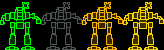

In [29]:
names = (
    "icon_bushwacker_green",
    "icon_bushwacker_grey",
    "icon_bushwacker_red",
    "icon_bushwacker_yellow",
)
compose = Image.new("RGB", (width * len(names), height))

for i, name in enumerate(names):
    _, texture = textures[name]
    pixels = unpack_from(f"<{size}H", texture)
    img = Image.frombytes("RGB", (width, height), bytes(rgb16_to_24(pixels)))
    compose.paste(img, (width * i, 0))
display_image(compose, width="800px")

Well that was easy. The red one looks a bit off...

In [30]:
header, texture = textures["hud_heat_bar"]
width = header[1]
height = header[2]
size = width * height
pixels = unpack_from(f"<{size}H", texture)
img = Image.frombytes("RGB", (width, height), bytes(rgb16_to_24(pixels)))
display_image(img)

Then again, that looks perfect. So why the new format? Well, none of these have alpha, but the black values should clearly be transparent. It's just a guess, and could probably be done with a blending mode in software, but why not output beautiful `.png` files while we're here?

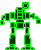

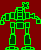

In [31]:
def rgb16_to_32(pixels):
    for pixel in pixels:
        yield ((pixel >> 11) & 0b11111) << 3
        yield ((pixel >> 5) & 0b111111) << 2
        yield ((pixel >> 0) & 0b11111) << 3
        yield 255 if pixel else 0


header, texture = textures["icon_bushwacker_green"]
width = header[1]
height = header[2]
size = width * height
pixels = unpack_from(f"<{size}H", texture)
img = Image.frombytes("RGBA", (width, height), bytes(rgb16_to_32(pixels)))
display_image(img, width="250px")
base = Image.new("RGBA", (width, height), color=(128, 0, 0, 255))
display_image(Image.alpha_composite(base, img), width="250px")

Not too shabby.

In [32]:
for tex_path in Path("install/v1.0-us-post/zbd").rglob("*tex*.zbd"):
    textures = read_textures(tex_path.read_bytes())
    # Commented out to avoid spam
    # print(tex_path, {(header[0],) + header[3:] for header, _ in textures.values()})

Yes, I get to decode the rest of the header! I'm more interested in the last value for now, so `c1/rtexture.zbd` is a good starting point. I'm also going to pick a format I understand somewhat.

In [33]:
path = Path("install/v1.0-us-post/zbd/c1/rtexture.zbd")
textures = read_textures(path.read_bytes())

interesting = [
    (name, header[-1])
    for name, (header, _) in textures.items()
    if header[-1] != 0 and header[0] == 5
]
print(interesting)

[('beach02', 1), ('c1conc03b', 1), ('c1conc04', 1), ('c1conc05', 1), ('sky01', 2), ('txsurf01', 1), ('txsurf02', 1), ('txsurf04', 1), ('txtrim01', 2), ('txtrim02', 2), ('txtrim04', 2), ('txwall01', 2), ('txwall06', 1), ('wave01', 1), ('wave02', 1), ('wave03', 1), ('wave04', 1), ('wave05', 1), ('wave06', 1), ('wave07', 1), ('wave08', 1), ('wave09', 1), ('wave10', 1), ('wave11', 1), ('wave12', 1), ('wave13', 1)]


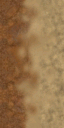

In [34]:
header, texture = textures["beach02"]
width = header[1]
height = header[2]
size = width * height
pixels = unpack_from(f"<{size}H", texture)
img = Image.frombytes("RGB", (width, height), bytes(rgb16_to_24(pixels)))
display_image(img)

This looks stretched. Could it be that easy?

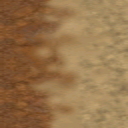

In [35]:
assert header[6] == 1
display_image(
    img.resize((width * 2, height), resample=Image.BICUBIC)
)  # BILINEAR, BICUBIC, LANCZOS, HAMMING

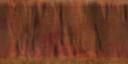

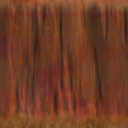

In [36]:
header, texture = textures["txtrim01"]
width = header[1]
height = header[2]
size = width * height
assert header[6] == 2
pixels = unpack_from(f"<{size}H", texture)
img = Image.frombytes("RGB", (width, height), bytes(rgb16_to_24(pixels)))
display_image(img)
display_image(
    img.resize((width, height * 2), resample=Image.BICUBIC)
)  # BILINEAR, BICUBIC, LANCZOS, HAMMING

Finally, `c1/texture.zbd`, and that other value.

In [37]:
path = Path("install/v1.0-us-post/zbd/c1/texture.zbd")
textures = read_textures(path.read_bytes())

print({header[5] for header, _ in textures.values()})

{1, 2, 3, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174, 176, 177, 178, 181, 182, 187, 188, 189, 190, 191, 194, 195, 196, 198, 199, 201, 203, 204, 205, 207, 213, 214, 215, 216, 218, 219, 221, 223, 226, 227, 228, 230, 232, 233, 236, 237, 239, 240, 245, 246, 247, 248, 250, 251, 256}


In [38]:
header, texture = textures["lasertur01"]
width = header[1]
height = header[2]
size = width * height
print(header[0])
len(texture) / size

165


1.07080078125

In [39]:
print(len(texture) - size)
print(header[5])

290
145


At this point, I'm pretty sure it's a palette-based image, and the palette is RGB565. It makes sense for the palette to be before the image data, but it's easy to check. None of the pixels can have a greater index than the palette count (Note: therefore, it's sensible to pick an image with a palette count less than 255, otherwise you can't tell).

In [40]:
pal_count = header[5]
pal_size = pal_count * 2

# palette at front
pixels = texture[pal_size:]
print(pal_count, min(pixels), max(pixels))

# palette at back
pixels = texture[:size]
print(pal_count, min(pixels), max(pixels))

145 2 241
145 0 144


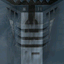

In [41]:
pixels = texture[:size]
palette = unpack_from(f"<{pal_count}H", texture, size)

img = Image.frombytes("P", (width, height), pixels)
img.putpalette(bytes(rgb16_to_24(palette)))
display_image(img)

Huzzah! Does it hold for all images?

In [42]:
all(
    ((header[5] * 2) == len(texture) - (header[1] * header[2]))
    for header, texture in textures.values()
)

False

In [43]:
header, texture = textures["lasertur01"]
header[0]

165

In [44]:
{header[0] for header, _ in textures.values()}

{165, 171}

In [45]:
all(
    ((header[5] * 2) == len(texture) - (header[1] * header[2]))
    for header, texture in textures.values()
    if header[0] == 165
)

True

This is just a guess, but if `165` is the palettised version of `5`, then `171` could be the palettised version of `11`, which included an alpha channel.

In [46]:
next(name for name, (header, _) in textures.items() if header[0] == 171)

'brlstn2'

In [47]:
header, texture = textures["brlstn2"]
width = header[1]
height = header[2]
size = width * height
pal_count = header[5]
pal_size = pal_count * 2
print(size, pal_size, len(texture) - size - pal_size)

4096 22 4096


If I'm reading this right, then the alpha channel is again uncompressed bytes. The question is where the alpha channel is stored. This is easiest done trying to display the alpha channel as grey scale.

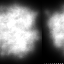

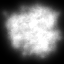

In [48]:
# palette before alpha
img = Image.frombytes(
    "L", (width, height), texture[size + pal_size : size * 2 + pal_size]
)
display_image(img)
# alpha before palette
img = Image.frombytes("L", (width, height), texture[size : size * 2])
display_image(img)

One of these looks better

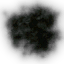

In [49]:
pixels = texture[0:size]
transparent = texture[size : size * 2]
palette = unpack_from(f"<{pal_count}H", texture, size * 2)

img = Image.frombytes("P", (width, height), pixels)
img.putpalette(bytes(rgb16_to_24(palette)))
img = img.convert("RGB")
alpha = Image.frombytes("L", (width, height), transparent)
img.putalpha(alpha)
display_image(img)

Maybe there's one with more colours to check.

In [50]:
print([name for name, (header, _) in textures.items() if header[0] == 171])

['brlstn2', 'ctfount01', 'ctfount03', 'ctfount05', 'drytree01', 'drytree02b', 'drytree03', 'drytree03s', 'drytree04', 'fish_boat03', 'gfly01', 'gfly02', 'gfly03', 'gfly04', 'gull01', 'jhwnd03a', 'lflare1', 'lflare2', 'lflare3', 'lflare4', 'm4rbrg01b', 'mf02', 'mfstack', 'pblb', 'poturr1', 'poturr2', 'shadow', 'shadow2', 'tmblweed', 'tpool01', 'txsurf06', 'BEAMBLUE', 'BEAMGRN', 'BEAMRED', 'GAUSMUZ', 'IMPACT01', 'IMPACT03', 'IMPACT04', 'IMPACT05', 'IMPACT06', 'IMPACT07', 'IMPACT08', 'IMPACT09', 'IMPACT10', 'Impact02', 'MACBLST', 'PPCMUZ', 'VAPOR01', 'WAYPOINT', 'bigwake', 'blood', 'blue_starburst', 'bsmok1', 'bsplsh02', 'bsplsh04', 'bsplsh06', 'bsplsh08', 'bsplsh10', 'bsplsh12', 'bsplsh14', 'bsplsh16', 'bsplsh18', 'bsplsh20', 'bushwacker_concrete', 'bushwacker_dirt', 'bushwacker_snow', 'cpit_crack01', 'cpit_ding01', 'crate01', 'crate02', 'crate03', 'crate04', 'crate05', 'crate06', 'crate07', 'crate08', 'crate09', 'crate10', 'crate11', 'crate12', 'crate13', 'crate14', 'dust01', 'fire_f01'

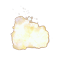

In [51]:
header, texture = textures["crate02"]
width = header[1]
height = header[2]
size = width * height
pal_count = header[5]
pal_size = pal_count * 2

pixels = texture[0:size]
transparent = texture[size : size * 2]
palette = unpack_from(f"<{pal_count}H", texture, size * 2)

img = Image.frombytes("P", (width, height), pixels)
img.putpalette(bytes(rgb16_to_24(palette)))
img = img.convert("RGB")
alpha = Image.frombytes("L", (width, height), transparent)
img.putalpha(alpha)
display_image(img)

And with that, all images can be decoded. Of course, there's probably not much point in decoding palette-based images when the RGB versions exist, other than sheer curiosity and preservation.

## Next up

[3D model extraction](07-mechlib.ipynb)

## Errata


There exist two textures with a stretch value of 3, `spotlight2` and `tertrans3`. They look fine as is, or simply lack detail to make the call, so I'm not sure what that value means.

In [52]:
path = Path("install/v1.0-us-post/zbd/c1/rtexture.zbd")
names1 = read_textures(path.read_bytes()).keys()

path = Path("install/v1.0-us-post/zbd/c1/texture.zbd")
names2 = read_textures(path.read_bytes()).keys()

names1 ^ names2

{'txgter_2'}

Oh come on! Why?

In [53]:
base = Path("install/v1.0-us-post/zbd/c1")
names1 = set()
for path in base.glob("rtexture*.zbd"):
    names1 |= read_textures(path.read_bytes()).keys()

names2 = set()
for path in base.glob("texture*.zbd"):
    names2 |= read_textures(path.read_bytes()).keys()

names1 ^ names2

{'BARSIDE2', 'BEACH01', 'BEACH02', 'SKY01', 'TMBLWEED', 'TPOOL01', 'txgter_2'}

In [54]:
names2 - names1

{'BEACH01', 'BEACH02', 'SKY01', 'txgter_2'}

In [55]:
names1 - names2

{'BARSIDE2', 'TMBLWEED', 'TPOOL01'}

I have to imagine these were left in by accident, since they seem otherwise unused:

```console
$ grep -rF 'txgter_2' install/v1.0-us-post/zbd
Binary file install/v1.0-us-post/zbd/c1/texture.zbd matches
Binary file install/v1.0-us-post/zbd/c1/texture1.zbd matches
Binary file install/v1.0-us-post/zbd/c1/texture2.zbd matches
```

Compared to e.g. `madcat_concrete`

```console
$ grep -rF 'madcat_concrete' install/v1.0-us-post/zbd
[...]
Binary file install/v1.0-us-post/zbd/interp.zbd matches
Binary file install/v1.0-us-post/zbd/reader.zbd matches
```